In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import seaborn as sns
sys.path.insert(0, os.path.abspath("../optimizer/"))
import utils
# import system_comparison_plots
%matplotlib inline


In [25]:
base_path = "/Users/crankshaw/clipper-project/model-comp-project/plots-model-comp-paper/experiments/e2e_sys_comp_pipeline_three/util_1.0"

all_results = []

for config in os.listdir(base_path):
    if os.path.splitext(config)[1] == ".json":
        with open(os.path.join(base_path, config)) as f:
            results = json.load(f)
            for r in results:
                all_results.append({
                    "slo": r["slo"],
                    "lambda": r["lam"],
                    "cost": r["cost"],
                    "CV": r["cv"],
                    "name": "inferline"
                })
    else:
        print(config)



.aws_resnet_cascade_ifl_configs_slo_0.35_cv_0.1_higher_cost.json.swp


In [26]:
rep_cost = utils.get_gpu_cost("aws", "v100", 3) + utils.get_cpu_cost("aws", 3)
base_path = "/Users/crankshaw/Downloads/CONFIGS_COST_SPD3"
for slo_d in os.listdir(base_path):
    pc = [base_path, slo_d]
    for cv_d in os.listdir(os.path.join(*pc)):
        pc = [base_path, slo_d, cv_d]
        for strat_d in os.listdir(os.path.join(*pc)):
            pc = [base_path, slo_d, cv_d, strat_d]
            for lam_d in os.listdir(os.path.join(*pc)):
                pc = [base_path, slo_d, cv_d, strat_d, lam_d]
                num_reps = 0
                for fname in os.listdir(os.path.join(*pc)):
                    if os.path.splitext(fname)[1] == ".json":
                        if num_reps == 0:
                            with open(os.path.join(*pc, fname)) as f:
                                cur_res = json.load(f)
                                slo = float(cur_res["slo_millis"]) / 1000.0
                                cv = cur_res["cv"]
                                lam = cur_res["lambda"]
                        num_reps += 1
                cost = rep_cost * num_reps
                all_results.append({
                    "slo": slo,
                    "lambda": lam,
                    "cost": cost,
                    "CV": cv,
                    "name": "SPD-{}".format(strat_d)
                })

                            


        

In [27]:
df = pd.DataFrame(all_results)

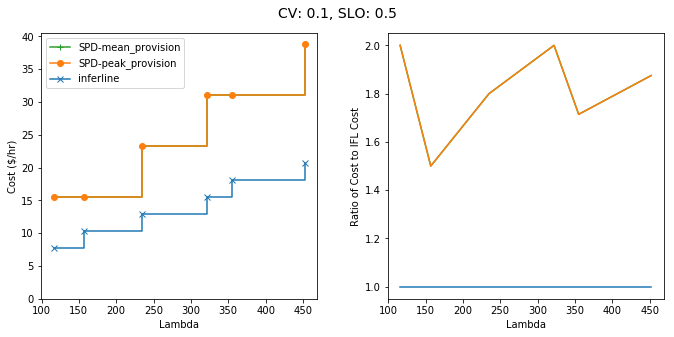

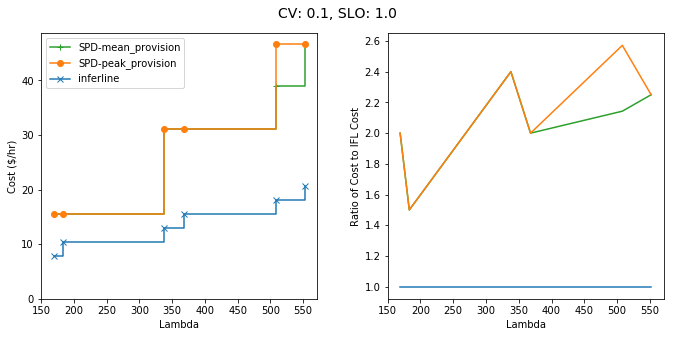

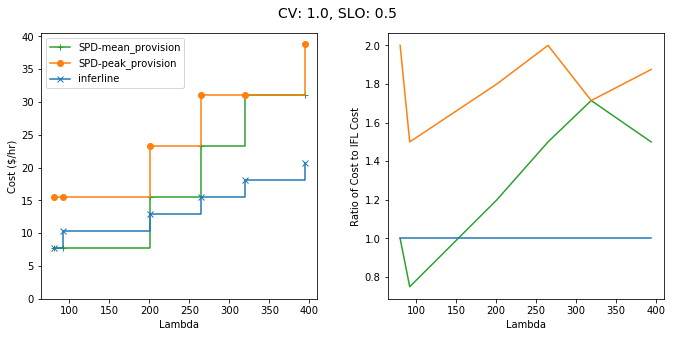

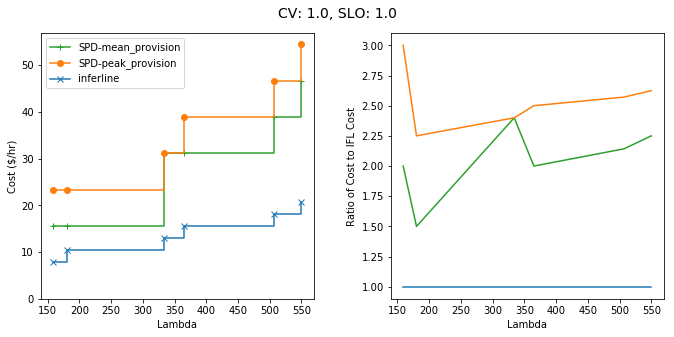

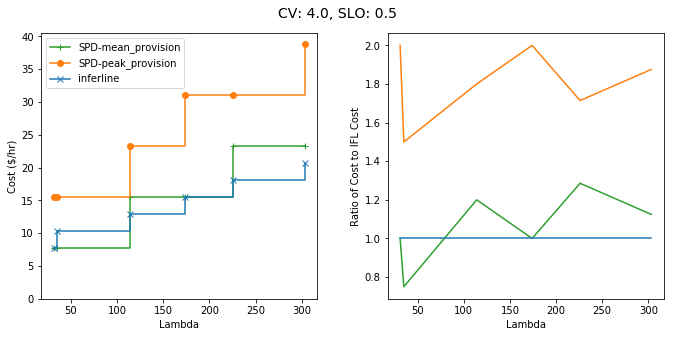

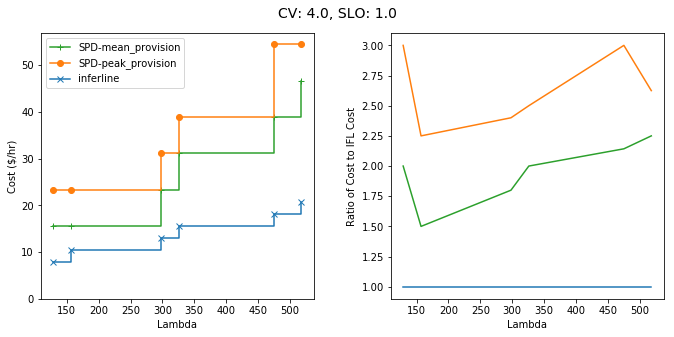

In [43]:
names = df.name.unique()
colors = sns.color_palette(n_colors=len(names))
cmap = dict(zip(names, colors))
ms = ["x", "o", "+"]
mmap = dict(zip(names, ms))

for cv, cv_group in df.groupby(df.CV):
    for slo, slo_group in cv_group.groupby(cv_group.slo):
        if slo == 0.35:
            continue
        fig, (ax_cost, ax_cost_ratio) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ng = slo_group.groupby(slo_group.name)
        ifl_costs = ng.get_group("inferline").sort_values("lambda")
        for name, name_group in ng:
            name_group = name_group.sort_values("lambda")
            ax_cost.step(name_group["lambda"], name_group.cost, mmap[name]+"-", where="post", c=cmap[name], label=name)
#             display(ng.get_group("inferline"))
#             display(ng.get_group(name))
            ax_cost_ratio.plot(name_group["lambda"], np.array(name_group.cost) / np.array(ifl_costs.cost), c=cmap[name], label=name)
        ax_cost.set_ylabel("Cost ($/hr)")
        ax_cost.set_xlabel("Lambda")
        ax_cost.set_ylim(bottom=0)
        ax_cost.legend(loc=0)
        ax_cost_ratio.set_ylabel("Ratio of Cost to IFL Cost")
        ax_cost_ratio.set_xlabel("Lambda")
        fig.suptitle("CV: {cv}, SLO: {slo}".format(cv=cv, slo=slo), fontsize=14)
        plt.tight_layout(pad=3)

            
    